In [71]:
import os
import time
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from torch.utils.data import TensorDataset, DataLoader

In [72]:
test_path = "../data/UNSW-NB15/UNSW_NB15_testing-set.csv"
df_test = pd.read_csv(test_path)
df_test.head()


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [73]:
feature_cols = [
    "dur","spkts","dpkts","sbytes","dbytes","rate","sttl","dttl","sload","dload",
    "sloss","dloss","sinpkt","dinpkt","smean","dmean","ct_srv_src","ct_state_ttl",
    "ct_dst_ltm","ct_src_dport_ltm"
]

label_col = "label"

X_test = df_test[feature_cols].astype("float32").values
y_test = df_test[label_col].astype("int64").values

X_test.shape, y_test.shape


((175341, 20), (175341,))

In [74]:
checkpoint = torch.load(
    "./tranwall.pt",
    map_location="cpu",
    weights_only=False
)

scaler_mean = checkpoint["scaler_mean"]
scaler_scale = checkpoint["scaler_scale"]
input_dim = checkpoint["input_dim"]
model_state = checkpoint["model_state_dict"]


In [75]:
X_test_scaled = (X_test - scaler_mean) / scaler_scale
X_test_tensor = torch.from_numpy(X_test_scaled).float()


In [76]:
class TranWallNet(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=8, num_layers=2, dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.cls_head = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.input_proj(x)
        x = x.unsqueeze(1)
        x = self.transformer(x)
        x = x[:, 0, :]
        logits = self.cls_head(x)
        return logits.squeeze(1)


In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TranWallNet(input_dim=input_dim).to(device)
model.load_state_dict(model_state)
model.eval()


TranWallNet(
  (input_proj): Linear(in_features=20, out_features=64, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (cls_head): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [78]:
with torch.no_grad():
    logits = model(X_test_tensor.to(device))
    probs = torch.sigmoid(logits)
    preds = (probs >= 0.5).long().cpu().numpy()


In [79]:
acc_trans = accuracy_score(y_test, preds)
f1_trans = f1_score(y_test, preds)
print(f"Test Accuracy: {acc_trans:.4f}, F1 Score: {f1_trans:.4f}")

Test Accuracy: 0.8897, F1 Score: 0.9137


In [80]:


precision_trans = precision_score(y_test, preds)
recall_trans = recall_score(y_test, preds)

print(f"Precision: {precision_trans:.4f}, Recall: {recall_trans:.4f}")

Precision: 0.9766, Recall: 0.8584


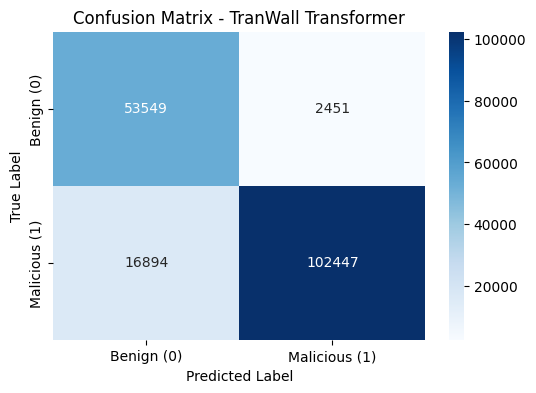

In [81]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, preds)

labels = ["Benign (0)", "Malicious (1)"]

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - TranWall Transformer")
plt.show()


In [82]:
csv_path = "../data/UNSW-NB15/UNSW_NB15_training-set.csv"
df = pd.read_csv(csv_path)
df.head()


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [83]:
feature_cols = [
    "dur",
    "spkts",
    "dpkts",
    "sbytes",
    "dbytes",
    "rate",
    "sttl",
    "dttl",
    "sload",
    "dload",
    "sloss",
    "dloss",
    "sinpkt",
    "dinpkt",
    "smean",
    "dmean",
    "ct_srv_src",
    "ct_state_ttl",
    "ct_dst_ltm",
    "ct_src_dport_ltm"
]

label_col = "label"

X = df[feature_cols].astype("float32").values
y = df[label_col].astype("int64").values

X.shape, y.shape

((82332, 20), (82332,))

In [84]:
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_np)
X_val_scaled = scaler.transform(X_val_np)

X_train_scaled.shape, X_val_scaled.shape


((65865, 20), (16467, 20))

In [85]:


rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_train_np, y_train_np)

y_pred_rf = rf.predict(X_val_np)
acc_rf = accuracy_score(y_val_np, y_pred_rf)
f1_rf = f1_score(y_val_np, y_pred_rf)

def benchmark_sklearn_model(model, X, n_repeats=3, batch_size=4096):
    start = time.perf_counter()
    n = 0
    for _ in range(n_repeats):
        for i in range(0, len(X), batch_size):
            _ = model.predict(X[i:i+batch_size])
            n += len(X[i:i+batch_size])
    elapsed = time.perf_counter() - start
    throughput = n / elapsed
    latency_ms = 1000.0 / throughput
    return throughput, latency_ms

throughput_rf, latency_rf = benchmark_sklearn_model(rf, X_val_np)

precision = precision_score(y_val_np, y_pred_rf)
recall = recall_score(y_val_np,y_pred_rf)

print(f"Accuracy: {acc_rf:.4f}, f1Score: {f1_rf:.4f}, \nPrecision: {precision:.4f}, Recall: {recall:.4f}, \nThroughput: {throughput_rf:.2f} samples/s, Latency: {latency_rf:.2f} ms/sample")


Accuracy: 0.9482, f1Score: 0.9524, 
Precision: 0.9642, Recall: 0.9409, 
Throughput: 20181.68 samples/s, Latency: 0.05 ms/sample


In [86]:
y_real_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_real_pred_rf)
f1_rf = f1_score(y_test, y_real_pred_rf)   
precision_rf = precision_score(y_test, y_real_pred_rf)
recall_rf = recall_score(y_test, y_real_pred_rf)
def benchmark_sklearn_model(model, X, n_repeats=3, batch_size=4096):
    start = time.perf_counter()
    n = 0
    for _ in range(n_repeats):
        for i in range(0, len(X), batch_size):
            _ = model.predict(X[i:i+batch_size])
            n += len(X[i:i+batch_size])
    elapsed = time.perf_counter() - start
    throughput = n / elapsed
    latency_ms = 1000.0 / throughput
    return throughput, latency_ms
throughput_rf, latency_rf = benchmark_sklearn_model(rf, X_val_np)

print(f"Accuracy: {acc_rf:.4f}, f1Score: {f1_rf:.4f}, \nPrecision: {precision_rf:.4f}, Recall: {recall_rf:.4f}, \nThroughput: {throughput_rf:.2f} samples/s, Latency: {latency_rf:.2f} ms/sample")

Accuracy: 0.9077, f1Score: 0.9289, 
Precision: 0.9769, Recall: 0.8854, 
Throughput: 20276.88 samples/s, Latency: 0.05 ms/sample


In [87]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


X_train_t = torch.tensor(X_train_np, dtype=torch.float32)
y_train_t = torch.tensor(y_train_np, dtype=torch.float32)
X_val_t = torch.tensor(X_val_np, dtype=torch.float32)
y_val_t = torch.tensor(y_val_np, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t, y_val_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256)
test_loader = DataLoader(test_ds, batch_size=256)

n_features = X_train_np.shape[1]

class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = x.unsqueeze(-1)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out.squeeze(1)

lstm_model = LSTMNet(input_dim=n_features).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)

def train_lstm(model, train_loader, val_loader, epochs=10):
    best_val_f1 = 0.0
    best_state = None
    for epoch in range(1, epochs + 1):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
        model.eval()
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                logits = model(xb)
                probs = torch.sigmoid(logits)
                preds = (probs >= 0.5).float().cpu().numpy()
                all_preds.append(preds)
                all_targets.append(yb.cpu().numpy())
        all_preds = np.concatenate(all_preds)
        all_targets = np.concatenate(all_targets)
        val_acc = accuracy_score(all_targets, all_preds)
        val_f1 = f1_score(all_targets, all_preds)
        print("Epoch", epoch, "val_acc", round(val_acc, 4), "val_f1", round(val_f1, 4))
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state = model.state_dict()
    if best_state is not None:
        model.load_state_dict(best_state)
train_lstm(lstm_model, train_loader, val_loader, epochs=10)

lstm_model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        logits = lstm_model(xb)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).float().cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)



Epoch 1 val_acc 0.8675 val_f1 0.8716
Epoch 2 val_acc 0.8771 val_f1 0.8824
Epoch 3 val_acc 0.8918 val_f1 0.8955
Epoch 4 val_acc 0.8994 val_f1 0.9073
Epoch 5 val_acc 0.8434 val_f1 0.873
Epoch 6 val_acc 0.9062 val_f1 0.9096
Epoch 7 val_acc 0.9033 val_f1 0.9063
Epoch 8 val_acc 0.9042 val_f1 0.9116
Epoch 9 val_acc 0.9142 val_f1 0.9188
Epoch 10 val_acc 0.9073 val_f1 0.9099


In [88]:

acc_lstm = accuracy_score(all_targets, all_preds)
f1_lstm = f1_score(all_targets, all_preds)
precision_lstm = precision_score(all_targets, all_preds)
recall_lstm = recall_score(all_targets, all_preds)

def benchmark_torch_model(model, X, batch_size=256, n_repeats=3):
    model.eval()
    X_t = torch.tensor(X, dtype=torch.float32).to(device)
    start = time.perf_counter()
    n = 0
    with torch.no_grad():
        for _ in range(n_repeats):
            for i in range(0, len(X_t), batch_size):
                xb = X_t[i:i+batch_size]
                logits = model(xb)
                _ = torch.sigmoid(logits)
                n += xb.size(0)
    elapsed = time.perf_counter() - start
    throughput = n / elapsed
    latency_ms = 1000.0 / throughput
    return throughput, latency_ms

throughput_lstm, latency_lstm = benchmark_torch_model(lstm_model, X_test)

acc_lstm, f1_lstm, precision_lstm, recall_lstm, throughput_lstm, latency_lstm
print(f"Accuracy: {acc_lstm:.4f}, F1 Score: {f1_lstm:.4f}, \nPrecision: {precision_lstm:.4f}, Recall: {recall_lstm:.4f}, \nThroughput: {throughput_lstm:.2f} samples/s, Latency: {latency_lstm:.2f} ms/sample")

Accuracy: 0.8713, F1 Score: 0.8965, 
Precision: 0.9901, Recall: 0.8192, 
Throughput: 328571.32 samples/s, Latency: 0.00 ms/sample


In [93]:
results = pd.DataFrame([
    ["Random Forest", acc_rf, f1_rf, precision_rf, recall_rf, throughput_rf, latency_rf],
    ["LSTM", acc_lstm, f1_lstm, precision_lstm, recall_lstm, throughput_lstm, latency_lstm],
    ["Transformer",acc_trans, f1_trans, precision_trans, recall_trans, throughput_lstm, latency_lstm],
], columns=["Model", "Accuracy", "F1", "Precision", "Recall", "Throughput_flows_per_sec", "Latency_ms_per_flow"])

results

,Model,Accuracy,F1,Precision,Recall,Throughput_flows_per_sec,Latency_ms_per_flow
0,Random Forest,0.907728,0.928886,0.976869,0.885396,20276.876573,0.049317
1,LSTM,0.871319,0.896539,0.990055,0.819165,328571.322098,0.003043
2,Transformer,0.889672,0.913730,0.976634,0.858439,328571.322098,0.003043
